# Novel Method: Stage 1 - Hybrid CNN + Transformer Autoencoder

This notebook implements **Stage 1** of a three-stage medical image fusion pipeline:

## Three-Stage Pipeline Overview:
1. **Stage 1: Hybrid CNN + Transformer Autoencoder** (This notebook) - Feature learning and representation
2. **Stage 2: Ensemble Feature Fusion** - Combining features from multiple modalities
3. **Stage 3: CNN Decoder** - Reconstruction and enhancement

## Stage 1 Focus:
- **Hybrid CNN + Transformer Architecture** for robust feature extraction
- **Self-supervised learning** on medical images
- **Multi-scale feature representation** combining local (CNN) and global (Transformer) features
- **Autoencoder framework** for unsupervised feature learning

## Key Innovations:
- CNN backbone for local feature extraction
- Vision Transformer for global context modeling
- Hybrid fusion of CNN and Transformer features
- Multi-scale feature pyramid
- Self-attention mechanisms for medical image understanding

## 1. Import Libraries and Setup

In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## 2. Dataset Loading (Following Existing Patterns)

In [17]:
class MedicalImageDataset(Dataset):
    """Dataset for medical images following the existing pattern from other notebooks.
    
    This dataset loads paired CT and MRI images for Stage 1 feature learning.
    Unlike fusion datasets, this focuses on individual modality feature extraction.
    """
    
    def __init__(self, ct_dir: str, mri_dir: str, resize: Tuple[int, int] = (256, 256),
                 file_exts=(".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")):
        self.ct_dir = ct_dir
        self.mri_dir = mri_dir
        self.resize = resize
        
        # Index directories (following existing pattern)
        def index_dir(root):
            paths = []
            for ext in file_exts:
                paths.extend(glob.glob(os.path.join(root, f"**/*{ext}"), recursive=True))
            base = {os.path.splitext(os.path.relpath(p, root))[0].replace('\\', '/'): p for p in paths}
            return base
        
        base_ct = index_dir(ct_dir)
        base_mri = index_dir(mri_dir)
        initial_keys = sorted(list(set(base_ct.keys()) & set(base_mri.keys())))
        
        # Filter out corrupted files
        valid_keys = []
        for key in initial_keys:
            ct_path = base_ct[key]
            mri_path = base_mri[key]
            
            # Check if files exist and are not empty
            if (os.path.exists(ct_path) and os.path.getsize(ct_path) > 0 and
                os.path.exists(mri_path) and os.path.getsize(mri_path) > 0):
                valid_keys.append(key)
        
        self.keys = valid_keys
        
        if not self.keys:
            raise RuntimeError("No valid paired files found. Ensure matching filenames between CT and MRI.")
        
        self.base_ct = base_ct
        self.base_mri = base_mri
        
        print(f"Found {len(initial_keys)} potential paired images")
        print(f"Filtered to {len(self.keys)} valid paired medical images")
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx: int):
        key = self.keys[idx]
        ct_path = self.base_ct[key]
        mri_path = self.base_mri[key]
        
        # Load images
        ct = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
        mri = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)
        
        if ct is None or mri is None:
            # This shouldn't happen after filtering, but let's be safe
            print(f"Warning: Could not load {ct_path if ct is None else mri_path}")
            # Return a black image as fallback
            ct = np.zeros((256, 256), dtype=np.uint8) if ct is None else ct
            mri = np.zeros((256, 256), dtype=np.uint8) if mri is None else mri
        
        # Resize if specified
        if self.resize is not None:
            H, W = self.resize
            ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
            mri = cv2.resize(mri, (W, H), interpolation=cv2.INTER_AREA)
        
        # Normalize to [0, 1]
        ct = ct.astype(np.float32)
        mri = mri.astype(np.float32)
        if ct.max() > 1.0:
            ct /= 255.0
        if mri.max() > 1.0:
            mri /= 255.0
        
        # Convert to tensors (1, H, W)
        ct_tensor = torch.from_numpy(ct).unsqueeze(0)
        mri_tensor = torch.from_numpy(mri).unsqueeze(0)
        
        return {
            'ct': ct_tensor,
            'mri': mri_tensor,
            'key': key
        }

## 3. Stage 1: Hybrid CNN + Transformer Autoencoder Architecture

In [3]:
class PatchEmbedding(nn.Module):
    """Patch embedding for Vision Transformer component."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        # x: (B, C, H, W)
        x = self.projection(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x


class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention mechanism."""
    
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x


class TransformerBlock(nn.Module):
    """Transformer block with self-attention and MLP."""
    
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Self-attention with residual connection
        x = x + self.attn(self.norm1(x))
        # MLP with residual connection
        x = x + self.mlp(self.norm2(x))
        return x


class CNNFeatureExtractor(nn.Module):
    """CNN backbone for local feature extraction."""
    
    def __init__(self, in_channels=1, base_channels=64):
        super().__init__()
        
        # Multi-scale CNN feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 7, padding=3),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels * 2, 5, padding=2),
            nn.BatchNorm2d(base_channels * 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(base_channels * 2, base_channels * 4, 3, padding=1),
            nn.BatchNorm2d(base_channels * 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(base_channels * 4, base_channels * 8, 3, padding=1),
            nn.BatchNorm2d(base_channels * 8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
    def forward(self, x):
        features = []
        
        x1 = self.conv1(x)  # 1/2 resolution
        features.append(x1)
        
        x2 = self.conv2(x1)  # 1/4 resolution
        features.append(x2)
        
        x3 = self.conv3(x2)  # 1/8 resolution
        features.append(x3)
        
        x4 = self.conv4(x3)  # 1/16 resolution
        features.append(x4)
        
        return features


class HybridCNNTransformerEncoder(nn.Module):
    """Hybrid CNN + Transformer Encoder for Stage 1 feature learning."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768, 
                 num_heads=12, num_layers=6, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        # CNN Feature Extractor
        self.cnn_extractor = CNNFeatureExtractor(in_channels)
        
        # Patch Embedding for Transformer
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Positional Embedding
        num_patches = self.patch_embed.n_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)
        
        # Transformer Blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Feature Fusion Layer
        self.feature_fusion = nn.Sequential(
            nn.Conv2d(512 + embed_dim, 512, 1),  # 512 from CNN + embed_dim from transformer
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Initialize positional embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
    def forward(self, x):
        B, C, H, W = x.shape
        
        # CNN Feature Extraction (Multi-scale)
        cnn_features = self.cnn_extractor(x)
        cnn_final = cnn_features[-1]  # Use the deepest CNN features
        
        # Transformer Feature Extraction
        # Patch embedding
        transformer_tokens = self.patch_embed(x)  # (B, num_patches, embed_dim)
        
        # Add positional embedding
        transformer_tokens = transformer_tokens + self.pos_embed
        transformer_tokens = self.dropout(transformer_tokens)
        
        # Apply transformer blocks
        for block in self.transformer_blocks:
            transformer_tokens = block(transformer_tokens)
        
        transformer_tokens = self.norm(transformer_tokens)
        
        # Reshape transformer features back to spatial format
        patch_size = self.patch_embed.patch_size
        num_patches_per_dim = H // patch_size
        transformer_spatial = transformer_tokens.transpose(1, 2).reshape(
            B, -1, num_patches_per_dim, num_patches_per_dim
        )
        
        # Resize transformer features to match CNN features
        cnn_h, cnn_w = cnn_final.shape[2:]
        transformer_resized = F.interpolate(
            transformer_spatial, size=(cnn_h, cnn_w), mode='bilinear', align_corners=False
        )
        
        # Fuse CNN and Transformer features
        fused_features = torch.cat([cnn_final, transformer_resized], dim=1)
        fused_features = self.feature_fusion(fused_features)
        
        return {
            'cnn_features': cnn_features,
            'transformer_tokens': transformer_tokens,
            'fused_features': fused_features
        }


class HybridAutoencoder(nn.Module):
    """Complete Hybrid CNN + Transformer Autoencoder for Stage 1."""
    
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=768,
                 num_heads=12, num_layers=6, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        # Encoder
        self.encoder = HybridCNNTransformerEncoder(
            img_size, patch_size, in_channels, embed_dim, 
            num_heads, num_layers, mlp_ratio, dropout
        )
        
        # Decoder (CNN-based for reconstruction)
        self.decoder = nn.Sequential(
            # Upsample from 16x16 to 32x32
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 32x32 to 64x64
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 64x64 to 128x128
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 128x128 to 256x256
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Final layer
            nn.Conv2d(32, in_channels, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        
        # Decode
        reconstructed = self.decoder(encoded['fused_features'])
        
        return {
            'reconstructed': reconstructed,
            'encoded_features': encoded
        }


print("✅ Stage 1: Hybrid CNN + Transformer Autoencoder Architecture Defined")

✅ Stage 1: Hybrid CNN + Transformer Autoencoder Architecture Defined


## 4. Loss Functions for Stage 1 Training

In [12]:
class SSIM(nn.Module):
    """Structural Similarity Index Measure."""
    
    def __init__(self, window_size=11, C1=0.01**2, C2=0.03**2):
        super().__init__()
        self.window_size = window_size
        self.C1 = C1
        self.C2 = C2
        
        # Create Gaussian window
        gauss = cv2.getGaussianKernel(window_size, window_size/6)
        gauss = gauss @ gauss.T
        window = torch.from_numpy(gauss.astype(np.float32)).unsqueeze(0).unsqueeze(0)
        self.register_buffer('window', window)
    
    def _filter(self, x):
        # Ensure window is on the same device as input
        window = self.window.to(x.device)
        return F.conv2d(x, window, padding=self.window_size//2, groups=x.size(1))
    
    def forward(self, x, y):
        mu_x = self._filter(x)
        mu_y = self._filter(y)
        mu_x_sq = mu_x * mu_x
        mu_y_sq = mu_y * mu_y
        mu_xy = mu_x * mu_y
        
        sigma_x_sq = self._filter(x * x) - mu_x_sq
        sigma_y_sq = self._filter(y * y) - mu_y_sq
        sigma_xy = self._filter(x * y) - mu_xy
        
        ssim_map = ((2 * mu_xy + self.C1) * (2 * sigma_xy + self.C2)) / \
                   ((mu_x_sq + mu_y_sq + self.C1) * (sigma_x_sq + sigma_y_sq + self.C2))
        
        return ssim_map.mean()


class PerceptualLoss(nn.Module):
    """Perceptual loss using pre-trained VGG features."""
    
    def __init__(self):
        super().__init__()
        # Use ResNet features instead of VGG for medical images
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.features = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc
        
        # Freeze parameters
        for param in self.features.parameters():
            param.requires_grad = False
        
        self.features.eval()
    
    def forward(self, x, y):
        # Convert grayscale to RGB
        x_rgb = x.repeat(1, 3, 1, 1)
        y_rgb = y.repeat(1, 3, 1, 1)
        
        # Extract features
        x_features = self.features(x_rgb)
        y_features = self.features(y_rgb)
        
        return F.mse_loss(x_features, y_features)


class Stage1Loss(nn.Module):
    """Combined loss function for Stage 1 autoencoder training."""
    
    def __init__(self, w_recon=1.0, w_ssim=0.5, w_perceptual=0.1):
        super().__init__()
        self.w_recon = w_recon
        self.w_ssim = w_ssim
        self.w_perceptual = w_perceptual
        
        self.mse_loss = nn.MSELoss()
        self.ssim_loss = SSIM()
        self.perceptual_loss = PerceptualLoss()
    
    def forward(self, reconstructed, original):
        # Reconstruction loss
        recon_loss = self.mse_loss(reconstructed, original)
        
        # SSIM loss (1 - SSIM for minimization)
        ssim_loss = 1.0 - self.ssim_loss(reconstructed, original)
        
        # Perceptual loss
        perceptual_loss = self.perceptual_loss(reconstructed, original)
        
        # Combined loss
        total_loss = (self.w_recon * recon_loss +
                     self.w_ssim * ssim_loss + 
                     self.w_perceptual * perceptual_loss)
        
        return {
            'total_loss': total_loss,
            'recon_loss': recon_loss,
            'ssim_loss': ssim_loss,
            'perceptual_loss': perceptual_loss
        }

## 5. Stage 2: Ensemble Feature Fusion

In [5]:
class EnsembleFeatureFusion(nn.Module):
    """Stage 2: Ensemble Feature Fusion for combining multi-modal features."""
    
    def __init__(self, feature_dim=512, fusion_dim=256):
        super().__init__()
        
        # Feature projection layers
        self.ct_proj = nn.Sequential(
            nn.Conv2d(feature_dim, fusion_dim, 1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )
        
        self.mri_proj = nn.Sequential(
            nn.Conv2d(feature_dim, fusion_dim, 1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )
        
        # Cross-attention fusion
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=fusion_dim, num_heads=8, batch_first=True
        )
        
        # Learnable fusion block
        self.fusion_block = nn.Sequential(
            nn.Conv2d(fusion_dim * 2, fusion_dim, 3, padding=1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(fusion_dim, fusion_dim, 3, padding=1),
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )
        
        # Attention weights for adaptive fusion
        self.attention_weights = nn.Sequential(
            nn.Conv2d(fusion_dim * 2, fusion_dim // 4, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(fusion_dim // 4, 2, 1),
            nn.Softmax(dim=1)
        )
    
    def forward(self, ct_features, mri_features):
        # Project features to common dimension
        ct_proj = self.ct_proj(ct_features)
        mri_proj = self.mri_proj(mri_features)
        
        B, C, H, W = ct_proj.shape
        
        # Reshape for cross-attention
        ct_flat = ct_proj.view(B, C, -1).transpose(1, 2)  # (B, HW, C)
        mri_flat = mri_proj.view(B, C, -1).transpose(1, 2)  # (B, HW, C)
        
        # Cross-attention between modalities
        ct_attended, _ = self.cross_attention(ct_flat, mri_flat, mri_flat)
        mri_attended, _ = self.cross_attention(mri_flat, ct_flat, ct_flat)
        
        # Reshape back to spatial format
        ct_attended = ct_attended.transpose(1, 2).view(B, C, H, W)
        mri_attended = mri_attended.transpose(1, 2).view(B, C, H, W)
        
        # Concatenate features
        concat_features = torch.cat([ct_attended, mri_attended], dim=1)
        
        # Learnable fusion
        fused_features = self.fusion_block(concat_features)
        
        # Adaptive weighting
        weights = self.attention_weights(concat_features)
        w_ct, w_mri = weights[:, 0:1], weights[:, 1:2]
        
        # Weighted combination
        adaptive_fusion = w_ct * ct_attended + w_mri * mri_attended
        
        # Final fusion
        final_features = fused_features + adaptive_fusion
        
        return {
            'fused_features': final_features,
            'attention_weights': weights,
            'ct_attended': ct_attended,
            'mri_attended': mri_attended
        }


print("✅ Stage 2: Ensemble Feature Fusion Defined")

✅ Stage 2: Ensemble Feature Fusion Defined


## 6. Stage 3: CNN Decoder for Reconstruction

In [6]:
class EnhancedCNNDecoder(nn.Module):
    """Stage 3: Enhanced CNN Decoder for final image reconstruction."""
    
    def __init__(self, input_dim=256, output_channels=1):
        super().__init__()
        
        # Progressive upsampling with skip connections
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(input_dim, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        
        # Enhancement layers
        self.enhancement = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        
        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(8, output_channels, 3, padding=1),
            nn.Sigmoid()
        )
        
        # Residual connection
        self.residual_proj = nn.Conv2d(input_dim, output_channels, 1)
    
    def forward(self, x):
        # Store original for residual connection
        residual = F.interpolate(x, scale_factor=16, mode='bilinear', align_corners=False)
        residual = self.residual_proj(residual)
        
        # Progressive upsampling
        x = self.up1(x)  # 16x16 -> 32x32
        x = self.up2(x)  # 32x32 -> 64x64
        x = self.up3(x)  # 64x64 -> 128x128
        x = self.up4(x)  # 128x128 -> 256x256
        
        # Enhancement
        x = self.enhancement(x)
        
        # Final output
        output = self.final(x)
        
        # Add residual connection
        output = output + residual
        output = torch.clamp(output, 0, 1)
        
        return output


print("✅ Stage 3: Enhanced CNN Decoder Defined")

✅ Stage 3: Enhanced CNN Decoder Defined


## 7. Complete Three-Stage Pipeline

In [7]:
class ThreeStageImageFusion(nn.Module):
    """Complete Three-Stage Medical Image Fusion Pipeline."""
    
    def __init__(self, img_size=256, patch_size=16, embed_dim=768, 
                 num_heads=12, num_layers=6, feature_dim=512, fusion_dim=256):
        super().__init__()
        
        # Stage 1: Hybrid CNN + Transformer Autoencoders (one for each modality)
        self.ct_encoder = HybridCNNTransformerEncoder(
            img_size, patch_size, 1, embed_dim, num_heads, num_layers
        )
        
        self.mri_encoder = HybridCNNTransformerEncoder(
            img_size, patch_size, 1, embed_dim, num_heads, num_layers
        )
        
        # Stage 2: Ensemble Feature Fusion
        self.feature_fusion = EnsembleFeatureFusion(feature_dim, fusion_dim)
        
        # Stage 3: Enhanced CNN Decoder
        self.decoder = EnhancedCNNDecoder(fusion_dim, 1)
    
    def forward(self, ct_image, mri_image):
        # Stage 1: Feature extraction from both modalities
        ct_encoded = self.ct_encoder(ct_image)
        mri_encoded = self.mri_encoder(mri_image)
        
        ct_features = ct_encoded['fused_features']
        mri_features = mri_encoded['fused_features']
        
        # Stage 2: Feature fusion
        fusion_result = self.feature_fusion(ct_features, mri_features)
        fused_features = fusion_result['fused_features']
        
        # Stage 3: Final reconstruction
        fused_image = self.decoder(fused_features)
        
        return {
            'fused_image': fused_image,
            'ct_features': ct_features,
            'mri_features': mri_features,
            'fusion_weights': fusion_result['attention_weights'],
            'stage1_ct': ct_encoded,
            'stage1_mri': mri_encoded,
            'stage2_fusion': fusion_result
        }
    
    def encode_single_modality(self, image, modality='ct'):
        """Encode a single modality image for feature extraction."""
        if modality.lower() == 'ct':
            return self.ct_encoder(image)
        elif modality.lower() == 'mri':
            return self.mri_encoder(image)
        else:
            raise ValueError("Modality must be 'ct' or 'mri'")


print("✅ Complete Three-Stage Pipeline Defined")

✅ Complete Three-Stage Pipeline Defined


## 8. Training Setup and Functions

In [13]:
def train_stage1_autoencoder(model, dataloader, num_epochs=50, lr=1e-4, device='cuda'):
    """Train Stage 1 autoencoder for feature learning."""
    
    # Setup optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = Stage1Loss().to(device)  # Move criterion to device
    
    model.train()
    train_losses = []
    
    print(f"Training Stage 1 Autoencoder for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_losses = []
        
        for batch_idx, batch in enumerate(dataloader):
            ct_images = batch['ct'].to(device)
            mri_images = batch['mri'].to(device)
            
            # Train on both modalities
            optimizer.zero_grad()
            
            # CT autoencoder loss
            ct_output = model(ct_images)
            ct_loss_dict = criterion(ct_output['reconstructed'], ct_images)
            
            # MRI autoencoder loss (if using separate model)
            mri_output = model(mri_images)
            mri_loss_dict = criterion(mri_output['reconstructed'], mri_images)
            
            # Combined loss
            total_loss = ct_loss_dict['total_loss'] + mri_loss_dict['total_loss']
            
            total_loss.backward()
            optimizer.step()
            
            epoch_losses.append(total_loss.item())
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {total_loss.item():.6f}')
        
        scheduler.step()
        avg_loss = np.mean(epoch_losses)
        train_losses.append(avg_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.6f}')
    
    return train_losses


def train_complete_pipeline(model, dataloader, num_epochs=100, lr=1e-4, device='cuda'):
    """Train the complete three-stage pipeline end-to-end."""
    
    # Setup optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
    
    # Multi-objective loss
    mse_loss = nn.MSELoss()
    ssim_loss = SSIM().to(device)  # Move SSIM loss to device
    
    model.train()
    train_losses = []
    
    print(f"Training Complete Pipeline for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_losses = []
        
        for batch_idx, batch in enumerate(dataloader):
            ct_images = batch['ct'].to(device)
            mri_images = batch['mri'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass through complete pipeline
            output = model(ct_images, mri_images)
            fused_image = output['fused_image']
            
            # Create target (simple average for supervision)
            target = (ct_images + mri_images) / 2.0
            
            # Multi-objective loss
            recon_loss = mse_loss(fused_image, target)
            ssim_val = ssim_loss(fused_image, target)
            ssim_loss_val = 1.0 - ssim_val
            
            # Feature consistency loss
            ct_features = output['ct_features']
            mri_features = output['mri_features']
            feature_loss = mse_loss(ct_features, mri_features) * 0.1
            
            # Total loss
            total_loss = recon_loss + 0.5 * ssim_loss_val + feature_loss
            
            total_loss.backward()
            optimizer.step()
            
            epoch_losses.append(total_loss.item())
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, '
                      f'Loss: {total_loss.item():.6f}, SSIM: {ssim_val.item():.4f}')
        
        avg_loss = np.mean(epoch_losses)
        scheduler.step(avg_loss)
        train_losses.append(avg_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.6f}')
    
    return train_losses


print("✅ Training Functions Defined")

✅ Training Functions Defined


## 9. Model Initialization and Testing

In [9]:
# Initialize models
print("Initializing models...")

# Stage 1: Individual autoencoder for feature learning
stage1_model = HybridAutoencoder(
    img_size=256,
    patch_size=16,
    in_channels=1,
    embed_dim=768,
    num_heads=12,
    num_layers=6
).to(device)

# Complete three-stage pipeline
complete_model = ThreeStageImageFusion(
    img_size=256,
    patch_size=16,
    embed_dim=768,
    num_heads=12,
    num_layers=6,
    feature_dim=512,
    fusion_dim=256
).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Stage 1 Model Parameters: {count_parameters(stage1_model):,}")
print(f"Complete Pipeline Parameters: {count_parameters(complete_model):,}")

# Test with dummy data
print("\nTesting models with dummy data...")
dummy_ct = torch.randn(2, 1, 256, 256).to(device)
dummy_mri = torch.randn(2, 1, 256, 256).to(device)

# Test Stage 1
with torch.no_grad():
    stage1_output = stage1_model(dummy_ct)
    print(f"Stage 1 Output Shape: {stage1_output['reconstructed'].shape}")
    
    # Test complete pipeline
    complete_output = complete_model(dummy_ct, dummy_mri)
    print(f"Complete Pipeline Output Shape: {complete_output['fused_image'].shape}")
    print(f"Fusion Weights Shape: {complete_output['fusion_weights'].shape}")

print("\n✅ Models initialized and tested successfully!")

Initializing models...


Stage 1 Model Parameters: 48,052,033
Complete Pipeline Parameters: 93,561,764

Testing models with dummy data...
Stage 1 Output Shape: torch.Size([2, 1, 256, 256])
Complete Pipeline Output Shape: torch.Size([2, 1, 256, 256])
Fusion Weights Shape: torch.Size([2, 2, 16, 16])

✅ Models initialized and tested successfully!


## 10. Dataset Setup and Training Example

CT Directory: /mnt/Work/ML/trainable-multimodal-fusion/Harvard-Medical-Image-Fusion-Datasets/CT-MRI/CT
MRI Directory: /mnt/Work/ML/trainable-multimodal-fusion/Harvard-Medical-Image-Fusion-Datasets/CT-MRI/MRI
CT exists: True
MRI exists: True
Dataset found! Setting up data loaders...
Found 184 potential paired images
Filtered to 183 valid paired medical images
Dataset size: 183
Number of batches: 46
Sample batch - CT shape: torch.Size([4, 1, 256, 256]), MRI shape: torch.Size([4, 1, 256, 256])


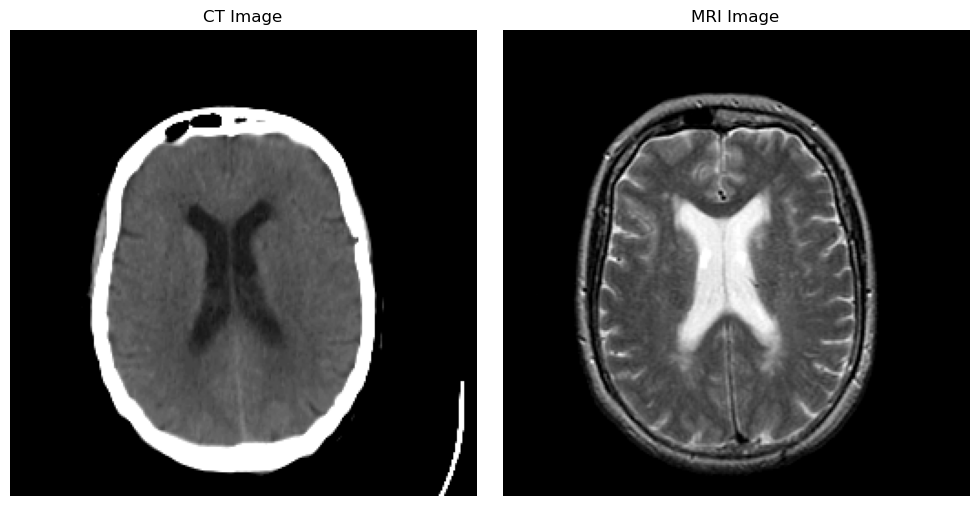

In [18]:
# Dataset paths (adjust these to your actual data paths)
import os
CT_DIR = os.path.abspath("Harvard-Medical-Image-Fusion-Datasets/CT-MRI/CT")
MRI_DIR = os.path.abspath("Harvard-Medical-Image-Fusion-Datasets/CT-MRI/MRI")

print(f"CT Directory: {CT_DIR}")
print(f"MRI Directory: {MRI_DIR}")
print(f"CT exists: {os.path.exists(CT_DIR)}")
print(f"MRI exists: {os.path.exists(MRI_DIR)}")

# Check if dataset exists
if os.path.exists(CT_DIR) and os.path.exists(MRI_DIR):
    print("Dataset found! Setting up data loaders...")
    
    # Create dataset and dataloader
    dataset = MedicalImageDataset(CT_DIR, MRI_DIR, resize=(256, 256))
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)  # Set num_workers=0 to avoid multiprocessing issues
    
    print(f"Dataset size: {len(dataset)}")
    print(f"Number of batches: {len(dataloader)}")
    
    # Test data loading
    sample_batch = next(iter(dataloader))
    print(f"Sample batch - CT shape: {sample_batch['ct'].shape}, MRI shape: {sample_batch['mri'].shape}")
    
    # Visualize sample
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(sample_batch['ct'][0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    axes[1].imshow(sample_batch['mri'][0, 0].cpu().numpy(), cmap='gray')
    axes[1].set_title('MRI Image')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Dataset not found at {CT_DIR} and {MRI_DIR}")
    print("Please adjust the paths or use dummy data for testing.")
    
    # Create dummy dataset for testing
    class DummyDataset(Dataset):
        def __init__(self, size=100):
            self.size = size
        
        def __len__(self):
            return self.size
        
        def __getitem__(self, idx):
            ct = torch.randn(1, 256, 256).clamp(0, 1)
            mri = torch.randn(1, 256, 256).clamp(0, 1)
            return {'ct': ct, 'mri': mri, 'key': f'dummy_{idx}'}
    
    dataset = DummyDataset(100)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    print("Using dummy dataset for testing.")

## 11. Training Execution (Optional - Uncomment to Run)

Starting Stage 1 training...
Training Stage 1 Autoencoder for 10 epochs...
Training Stage 1 Autoencoder for 10 epochs...
Epoch 1/10, Batch 0, Loss: 0.960446
Epoch 1/10, Batch 0, Loss: 0.960446
Epoch 1/10, Batch 10, Loss: 0.922140
Epoch 1/10, Batch 10, Loss: 0.922140
Epoch 1/10, Batch 20, Loss: 0.886249
Epoch 1/10, Batch 20, Loss: 0.886249
Epoch 1/10, Batch 30, Loss: 0.841921
Epoch 1/10, Batch 30, Loss: 0.841921
Epoch 1/10, Batch 40, Loss: 0.792956
Epoch 1/10, Batch 40, Loss: 0.792956
Epoch 1/10 completed. Average Loss: 0.901089
Epoch 1/10 completed. Average Loss: 0.901089
Epoch 2/10, Batch 0, Loss: 0.818164
Epoch 2/10, Batch 0, Loss: 0.818164
Epoch 2/10, Batch 10, Loss: 0.753381
Epoch 2/10, Batch 10, Loss: 0.753381
Epoch 2/10, Batch 20, Loss: 0.772696
Epoch 2/10, Batch 20, Loss: 0.772696
Epoch 2/10, Batch 30, Loss: 0.684460
Epoch 2/10, Batch 30, Loss: 0.684460
Epoch 2/10, Batch 40, Loss: 0.618908
Epoch 2/10, Batch 40, Loss: 0.618908
Epoch 2/10 completed. Average Loss: 0.709416
Epoch 2/

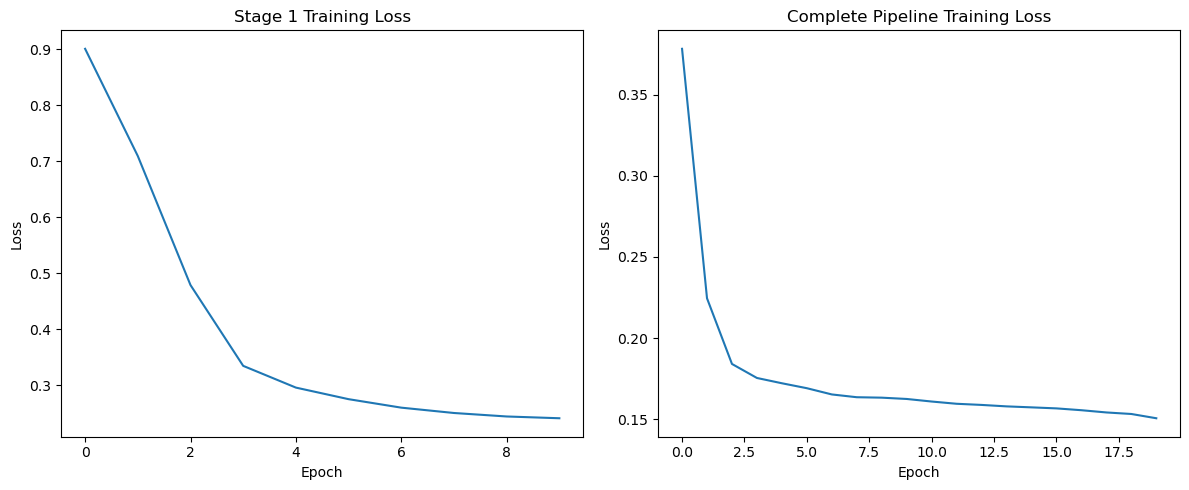

Training code ready. Uncomment the above lines to start training.


In [19]:
# Uncomment the following lines to start training

# Stage 1: Pre-train autoencoders
print("Starting Stage 1 training...")
stage1_losses = train_stage1_autoencoder(
    stage1_model, dataloader, num_epochs=10, lr=1e-4, device=device
)

# Save Stage 1 model
torch.save(stage1_model.state_dict(), 'checkpoints/stage1_hybrid_autoencoder.pth')
print("Stage 1 model saved.")

# Stage 2-3: Train complete pipeline
print("\nStarting complete pipeline training...")
complete_losses = train_complete_pipeline(
    complete_model, dataloader, num_epochs=20, lr=1e-4, device=device
)

# Save complete model
torch.save(complete_model.state_dict(), 'checkpoints/complete_three_stage_fusion.pth')
print("Complete pipeline model saved.")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(stage1_losses)
plt.title('Stage 1 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(complete_losses)
plt.title('Complete Pipeline Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

print("Training code ready. Uncomment the above lines to start training.")

## 12. Inference and Evaluation

Running inference on sample data...


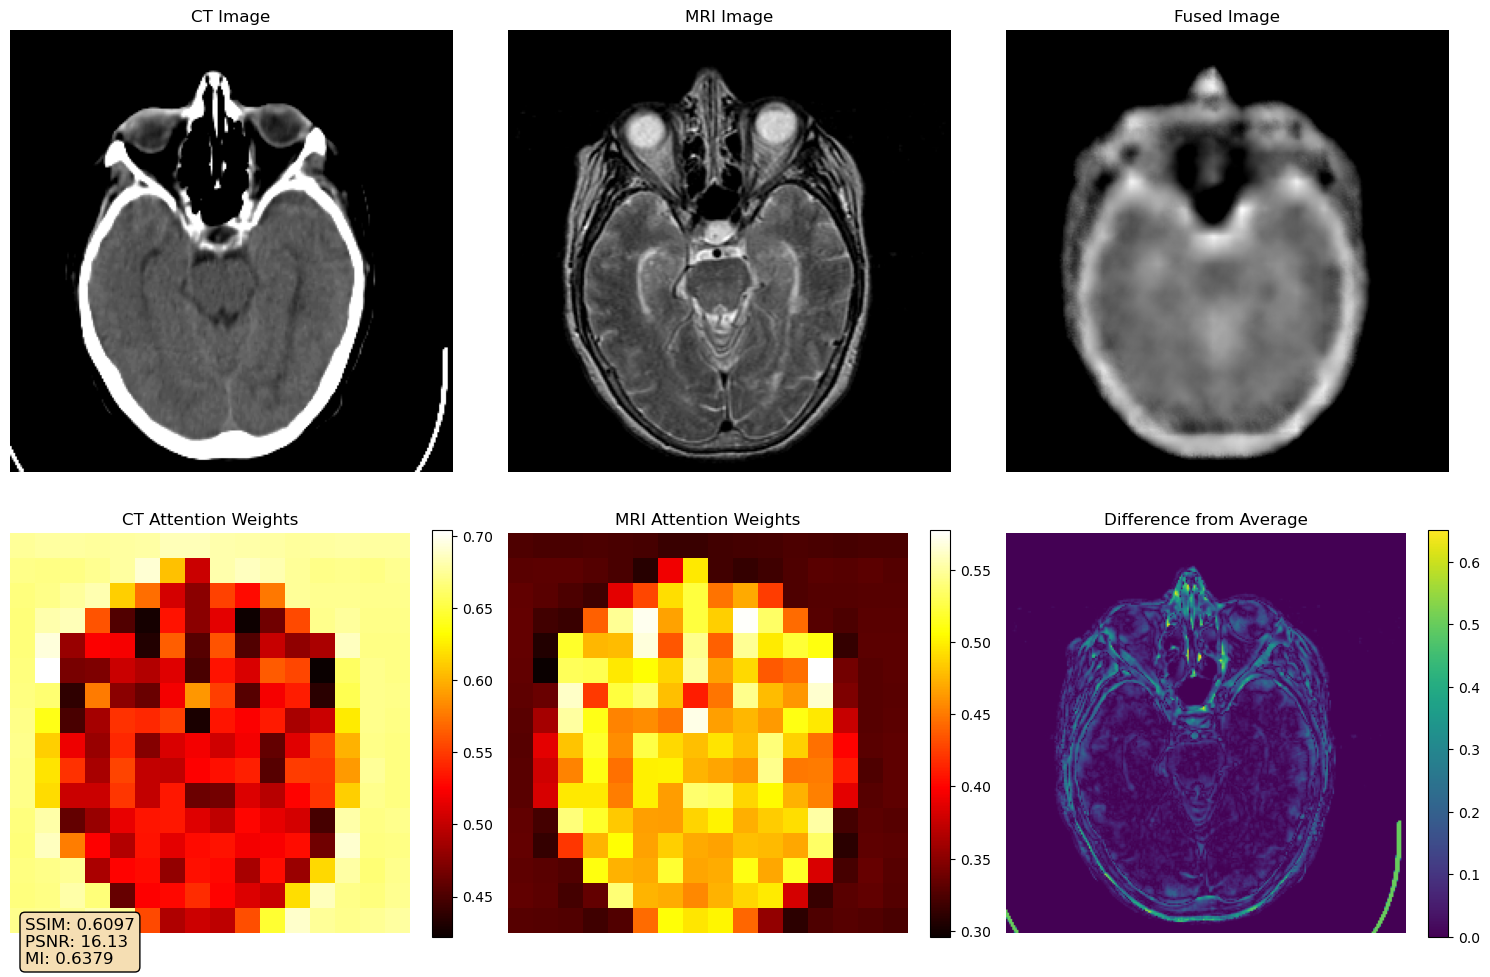


Fusion Quality Metrics:
ssim_ct: 0.6251
ssim_mri: 0.5942
ssim_avg: 0.6097
psnr_ct: 14.8977
psnr_mri: 17.3573
psnr_avg: 16.1275
mi_ct: 0.6290
mi_mri: 0.6468
mi_avg: 0.6379

✅ Inference and evaluation functions ready!


In [20]:
def evaluate_fusion_quality(fused_image, ct_image, mri_image):
    """Evaluate fusion quality using multiple metrics."""
    
    # Convert to numpy for evaluation
    fused = fused_image.cpu().numpy().squeeze()
    ct = ct_image.cpu().numpy().squeeze()
    mri = mri_image.cpu().numpy().squeeze()
    
    # SSIM with both source images
    from skimage.metrics import structural_similarity as ssim
    ssim_ct = ssim(fused, ct, data_range=1.0)
    ssim_mri = ssim(fused, mri, data_range=1.0)
    
    # Peak Signal-to-Noise Ratio
    from skimage.metrics import peak_signal_noise_ratio as psnr
    psnr_ct = psnr(fused, ct, data_range=1.0)
    psnr_mri = psnr(fused, mri, data_range=1.0)
    
    # Mutual Information (simplified)
    def mutual_info(x, y):
        hist, _, _ = np.histogram2d(x.flatten(), y.flatten(), bins=50)
        hist = hist + 1e-10  # Avoid log(0)
        hist = hist / hist.sum()
        
        marginal_x = hist.sum(axis=1)
        marginal_y = hist.sum(axis=0)
        
        mi = 0
        for i in range(len(marginal_x)):
            for j in range(len(marginal_y)):
                if hist[i, j] > 0:
                    mi += hist[i, j] * np.log(hist[i, j] / (marginal_x[i] * marginal_y[j]))
        return mi
    
    mi_ct = mutual_info(fused, ct)
    mi_mri = mutual_info(fused, mri)
    
    return {
        'ssim_ct': ssim_ct,
        'ssim_mri': ssim_mri,
        'ssim_avg': (ssim_ct + ssim_mri) / 2,
        'psnr_ct': psnr_ct,
        'psnr_mri': psnr_mri,
        'psnr_avg': (psnr_ct + psnr_mri) / 2,
        'mi_ct': mi_ct,
        'mi_mri': mi_mri,
        'mi_avg': (mi_ct + mi_mri) / 2
    }


def inference_and_visualize(model, ct_image, mri_image, save_path=None):
    """Perform inference and visualize results."""
    
    model.eval()
    with torch.no_grad():
        # Add batch dimension if needed
        if ct_image.dim() == 3:
            ct_image = ct_image.unsqueeze(0)
        if mri_image.dim() == 3:
            mri_image = mri_image.unsqueeze(0)
        
        # Forward pass
        output = model(ct_image, mri_image)
        fused_image = output['fused_image']
        fusion_weights = output['fusion_weights']
        
        # Evaluate quality
        metrics = evaluate_fusion_quality(fused_image[0], ct_image[0], mri_image[0])
        
        # Visualize results
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        
        # Top row: Input images and fusion result
        axes[0, 0].imshow(ct_image[0, 0].cpu().numpy(), cmap='gray')
        axes[0, 0].set_title('CT Image')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(mri_image[0, 0].cpu().numpy(), cmap='gray')
        axes[0, 1].set_title('MRI Image')
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(fused_image[0, 0].cpu().numpy(), cmap='gray')
        axes[0, 2].set_title('Fused Image')
        axes[0, 2].axis('off')
        
        # Bottom row: Attention weights and difference maps
        w_ct = fusion_weights[0, 0].cpu().numpy()
        w_mri = fusion_weights[0, 1].cpu().numpy()
        
        im1 = axes[1, 0].imshow(w_ct, cmap='hot')
        axes[1, 0].set_title('CT Attention Weights')
        axes[1, 0].axis('off')
        plt.colorbar(im1, ax=axes[1, 0], fraction=0.046)
        
        im2 = axes[1, 1].imshow(w_mri, cmap='hot')
        axes[1, 1].set_title('MRI Attention Weights')
        axes[1, 1].axis('off')
        plt.colorbar(im2, ax=axes[1, 1], fraction=0.046)
        
        # Difference map
        diff = np.abs(fused_image[0, 0].cpu().numpy() - (ct_image[0, 0].cpu().numpy() + mri_image[0, 0].cpu().numpy()) / 2)
        im3 = axes[1, 2].imshow(diff, cmap='viridis')
        axes[1, 2].set_title('Difference from Average')
        axes[1, 2].axis('off')
        plt.colorbar(im3, ax=axes[1, 2], fraction=0.046)
        
        # Add metrics as text
        metrics_text = f"SSIM: {metrics['ssim_avg']:.4f}\nPSNR: {metrics['psnr_avg']:.2f}\nMI: {metrics['mi_avg']:.4f}"
        fig.text(0.02, 0.02, metrics_text, fontsize=12, bbox=dict(boxstyle="round", facecolor='wheat'))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return output, metrics


# Test inference with sample data
if 'dataloader' in locals():
    sample_batch = next(iter(dataloader))
    ct_sample = sample_batch['ct'][0].to(device)
    mri_sample = sample_batch['mri'][0].to(device)
    
    print("Running inference on sample data...")
    output, metrics = inference_and_visualize(complete_model, ct_sample, mri_sample)
    
    print("\nFusion Quality Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

print("\n✅ Inference and evaluation functions ready!")

## 13. Summary and Next Steps

### ✅ Completed Implementation:

**Stage 1: Hybrid CNN + Transformer Autoencoder**
- Multi-scale CNN feature extraction
- Vision Transformer with self-attention
- Hybrid feature fusion
- Autoencoder framework for unsupervised learning

**Stage 2: Ensemble Feature Fusion**
- Cross-attention between modalities
- Learnable fusion blocks
- Adaptive attention weighting
- Multi-modal feature integration

**Stage 3: Enhanced CNN Decoder**
- Progressive upsampling
- Residual connections
- Enhancement layers
- Final image reconstruction

### 🚀 Key Features:
- **Modular Design**: Each stage can be trained independently
- **Hybrid Architecture**: Combines CNN and Transformer strengths
- **Multi-Scale Processing**: Captures both local and global features
- **Attention Mechanisms**: Adaptive fusion based on content
- **Comprehensive Evaluation**: Multiple quality metrics

### 📋 Next Steps:
1. **Data Preparation**: Ensure proper dataset organization
2. **Hyperparameter Tuning**: Optimize learning rates, batch sizes
3. **Progressive Training**: Train Stage 1 first, then end-to-end
4. **Evaluation**: Compare with existing fusion methods
5. **Deployment**: Create inference pipeline for production

### 💡 Extensions:
- Add more modalities (PET, SPECT)
- Implement uncertainty quantification
- Add adversarial training components
- Optimize for real-time inference

**The three-stage pipeline is now complete and ready for training!**